In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import re

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

In [2]:
RANDOM_SEED = 42

# DATA

In [3]:
df_train = pd.read_csv('main_task.xls') # данные, необходимые для обучения модели
df_test = pd.read_csv('kaggle_task.csv') # сведения о ресторанах, для которых необходимо предсказать рейтинг
sample_submission = pd.read_csv('sample_submission.csv') # образец оформления результата

In [4]:
df_train.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
1048,id_3713,London,"['Italian', 'Mediterranean', 'Vegetarian Frien...",3720.0,4.0,$$ - $$$,298.0,"[['Meatballs to die for!!', 'Nice food. Slight...",/Restaurant_Review-g186338-d3508464-Reviews-Po...,d3508464
36985,id_1720,Stockholm,"['European', 'Scandinavian']",1723.0,4.0,$$ - $$$,NaN,"[[], []]",/Restaurant_Review-g189852-d12922691-Reviews-P...,d12922691
3237,id_5051,Milan,NaN,5054.0,4.0,NaN,5.0,"[['This is my favourite bar'], ['12/14/2015']]",/Restaurant_Review-g187849-d8339797-Reviews-De...,d8339797
26973,id_4168,Madrid,NaN,4170.0,5.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187514-d990826-Reviews-Qui...,d990826
2546,id_524,Amsterdam,"['European', 'Vegetarian Friendly', 'Vegan Opt...",525.0,4.5,$$ - $$$,137.0,"[['A very special meal', 'Very unique and beau...",/Restaurant_Review-g188590-d753235-Reviews-Bet...,d753235


Подробнее по признакам:
* Restaurant_id - id компании (может быть представлена в разных городах, сеть ресторанов например)
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана (целевая переменная)

In [5]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

data1 = data.copy() # на всякий случай создадим копию начального датасета

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


# Очистка и предобработка данных

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [7]:
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')
data['Cuisine Style_isNAN'] = pd.isna(data['Cuisine Style']).astype('uint8')
data['Price Range_isNAN'] = pd.isna(data['Price Range']).astype('uint8')

Чтобы понять, какими значениями заполнять пропущенные значения, посмотрим на распределение значений данного признака:

### Number of Reviews

In [8]:
data['Number of Reviews'].describe()

count    46800.000000
mean       124.471197
std        294.114345
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: Number of Reviews, dtype: float64

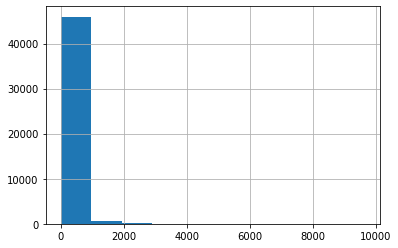

In [9]:
data['Number of Reviews'].hist()

In [10]:
data['Number of Reviews'].value_counts(bins=100, normalize=True)[:5]

(-7.659000000000001, 98.58]    0.67548
(98.58, 195.16]                0.10834
(195.16, 291.74]               0.05020
(291.74, 388.32]               0.02964
(388.32, 484.9]                0.01792
Name: Number of Reviews, dtype: float64

Из чего следует, что 2/3 ресторанов имеют не более 100 отзывов. Пропущенные значения будем заполнять нулями - это будет говорить о том, что раз сведения об отзывах отсутствуют, значит их на данный момент нет:

In [11]:
data['Number of Reviews'].fillna(0, inplace=True)

### Price Range

Посмотрим на признак Price Range - цены в ресторане:

In [12]:
data['Price Range'].unique()

array(['$$ - $$$', '$$$$', '$', nan], dtype=object)

Переобозначим эти ценовые категории как 1, 2 и 3:

In [13]:
price_range_dict = {'$': 1, '$$ - $$$': 2, '$$$$': 3}
data['Price Range'] = data['Price Range'].replace(price_range_dict)

Посмотрим теперь на распределение ценовых категорий в ресторанах:

In [14]:
data['Price Range'].describe()

count    32639.000000
mean         1.815129
std          0.509800
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          3.000000
Name: Price Range, dtype: float64

Заполним пропуски медианным значением - 2 ценовой категорией:

In [15]:
data['Price Range'].fillna(data['Price Range'].median(), inplace=True)

### Cuisine Style

Признак Cuisinie Style (Кухня) представлен в виде списка кухонь для каждого ресторана. Создадим новый признак, куда запишем количество кухонь и посмотрим на то, сколько всего видов кухонь существует:

In [16]:
data['Number_of_cuisine'] = data['Cuisine Style'].apply(lambda x: len(str(x)[1:-1].split(', ')))

cuisine_styles = data['Cuisine Style'].dropna().apply(lambda x: str(x)[1:-1].split(', ')).sum()

pd.Series(cuisine_styles).value_counts()

'Vegetarian Friendly'    14021
'European'               12561
'Mediterranean'           7820
'Italian'                 7433
'Vegan Options'           5684
                         ...  
'Polynesian'                 2
'Salvadoran'                 1
'Latvian'                    1
'Burmese'                    1
'Xinjiang'                   1
Length: 125, dtype: int64

Всего 125 видов кухонь, самая популярная Vegetarian Friendly. Посмотрим на распределение количества кухонь в ресторанах:

In [17]:
data['Number_of_cuisine'].value_counts()

1     20744
2      7794
3      6638
4      5948
5      4482
6      2611
7      1294
8       363
9        93
10       26
11        4
21        1
15        1
13        1
Name: Number_of_cuisine, dtype: int64

In [18]:
data['Number_of_cuisine'].describe()

count    50000.000000
mean         2.625320
std          1.824029
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         21.000000
Name: Number_of_cuisine, dtype: float64

25% ресторанов представлены только одним видом кухни, 50% имеют не более 2 кухонь, 75% не более 4. Заполним пропуски медианным значением:

In [19]:
data['Number_of_cuisine'].fillna(data['Number_of_cuisine'].median(), inplace=True)

## 2. Предобработка данных

### Reviews

Посмотрим, как выглядят значения признака Reviews:

In [20]:
data['Reviews'].sample().values

array(["[['Good for breakfast and brunch', '3 € for each glass of water'], ['05/06/2017', '06/24/2017']]"],
      dtype=object)

Значения состоят из списка с двумя элементами: первый элемент - текст двух последних отзывов, второй элемент - даты этих отзывов. Нам могут пригодиться даты, извлечем их в отдельные признаки для дальнейшей работы с ними:

In [21]:
pattern = re.compile('\d\d/\d\d/\d\d\d\d')

pattern.findall(str(data.Reviews[1]))

['12/05/2017', '10/29/2017']

In [22]:
data['date_reviews'] = data['Reviews'].apply(lambda x: pattern.findall(str(x)))

data['date1'] = pd.to_datetime(data['date_reviews'].apply(lambda x: x[0] if len(x)>0 else None))
data['date2'] = pd.to_datetime(data['date_reviews'].apply(lambda x: x[1] if len(x)>1 else None))

У некоторых ресторанов могли отсутствовать даты отзывов или присутствовал только один из двух отзывов:

In [23]:
data[['date1','date2']].isna().sum()

date1     8114
date2    13794
dtype: int64

In [24]:
data[data['date1'].isna()]['date2'].isna().sum()

8114

In [25]:
data[~(data['date1'].isna())]['date2'].isna().sum()

5680

In [26]:
data[~(data['date2'].isna())]['date1'].isna().sum()

0

У 8114 ресторанов отсутсвуют даты как первого, так и второго последних отзывов. У 5680 ресторанов есть только один отзыв. 

### ID_TA

 В значенния данного признака содержится число - id ресторана в TripAdvisor. Извлечем его и перезапишем в этот же столбец:

In [27]:
data['ID_TA'] = data['ID_TA'].apply(lambda x: int(x[1:]))

Посмотрим теперь на наш датасет, что получилось:

In [28]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Cuisine Style_isNAN,Price Range_isNAN,Number_of_cuisine,date_reviews,date1,date2
44597,id_2187,Stockholm,NaN,2190.0,2.0,2.0,"[[""Wouldn't eat here again."", 'A total rip off...",/Restaurant_Review-g189852-d13198094-Reviews-F...,13198094,1,3.0,0,1,1,1,"[01/01/2018, 01/09/2018]",2018-01-01,2018-01-09
28088,id_3173,Milan,['Pizza'],3175.0,1.0,20.0,"[['Perfect!', 'Try it out!'], ['05/24/2017', '...",/Restaurant_Review-g187849-d3479294-Reviews-A_...,3479294,1,4.5,0,0,0,1,"[05/24/2017, 10/21/2015]",2017-05-24,2015-10-21
47758,id_1765,Stockholm,NaN,1768.0,2.0,26.0,"[['Mansplaining waiter, expensive and delicio....",/Restaurant_Review-g189852-d1207089-Reviews-Wi...,1207089,1,4.0,0,1,1,1,"[11/02/2016, 04/10/2016]",2016-11-02,2016-04-10
6733,id_6733,Paris,"['Brew Pub', 'Bar', 'Pub', 'Wine Bar']",8060.0,2.0,2.0,"[['What a great joint!', 'Super bar- great amb...",/Restaurant_Review-g187147-d11810616-Reviews-L...,11810616,0,0.0,0,0,0,4,"[11/17/2017, 11/15/2016]",2017-11-17,2016-11-15
141,id_141,Barcelona,"['Italian', 'Mediterranean', 'Spanish']",4180.0,2.0,0.0,"[['Real treasure'], ['10/20/2017']]",/Restaurant_Review-g187497-d12530776-Reviews-C...,12530776,0,0.0,1,0,0,3,[10/20/2017],2017-10-20,NaT


Избавимся от признаков, которые дальше не пригодятся:

In [29]:
data.drop(['Cuisine Style','Reviews','URL_TA','date_reviews'], axis = 1, inplace=True)
data.sample(5)

,Restaurant_id,City,Ranking,Price Range,Number of Reviews,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Cuisine Style_isNAN,Price Range_isNAN,Number_of_cuisine,date1,date2
33881,id_14378,London,14389.0,2.0,32.0,5439526,1,3.0,0,0,0,2,2017-09-27,2016-12-03
21397,id_835,Geneva,840.0,2.0,3.0,11659467,1,4.5,0,1,1,1,2018-01-05,NaT
10595,id_1986,Prague,1989.0,2.0,0.0,4768291,1,5.0,1,0,1,2,2015-05-15,NaT
45978,id_1121,Edinburgh,1122.0,2.0,10.0,7724894,1,4.5,0,0,1,5,2016-11-26,2016-08-11
21671,id_1053,Amsterdam,1056.0,2.0,42.0,4267945,1,4.5,0,0,0,7,2017-02-17,2017-01-14


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Restaurant_id            50000 non-null  object        
 1   City                     50000 non-null  object        
 2   Ranking                  50000 non-null  float64       
 3   Price Range              50000 non-null  float64       
 4   Number of Reviews        50000 non-null  float64       
 5   ID_TA                    50000 non-null  int64         
 6   sample                   50000 non-null  int64         
 7   Rating                   50000 non-null  float64       
 8   Number_of_Reviews_isNAN  50000 non-null  uint8         
 9   Cuisine Style_isNAN      50000 non-null  uint8         
 10  Price Range_isNAN        50000 non-null  uint8         
 11  Number_of_cuisine        50000 non-null  int64         
 12  date1                    41886 n

# EDA

Изучим распределения признаков, взаимосвязи признаков между собой.

Важное предположение, которое затем подтвердилось улучшением точности предсказания модели: значение Ranking, как следует из описания, рассчитывалось **относительно других ресторанов в этом городе**. Поэтому нужно стандартизировать значения признаков относительно значений в каждом конкретном городе.

### Restaurant_id

Значение Restaurant_id само по себе никакой полезной информации не несёт - это всего лишь пронумерованный список. Но есть один важный момент - у нас могут попадаться сети ресторанов, которые представлены разным количеством:

In [31]:
pd.Series(data.Restaurant_id.value_counts().values).value_counts()

1     3807
2     2555
3     1845
4     1226
5      812
6      514
7      413
8      384
10     332
9      311
11     255
12     221
13     151
14     129
15      74
16      37
17      18
18       6
19       4
dtype: int64

Есть уникальные рестораны (3807 шт.), которые встречаются только в одном городе. А есть большие сети (4 шт.), у которых по 19 ресторанов. На основании этих данных можно сформировать новые признаки - является ли ресторан уникальным или принадлежит какой-то сети ресторанов.

In [32]:
data = data.reset_index()

restaurant_id_count = data.groupby('Restaurant_id').Restaurant_id.count()

data['restaurant_id_count'] = data['Restaurant_id'].map(restaurant_id_count)

# количество ресторанов определенной сети в конкретном городе
count_rest_id_in_city = pd.pivot_table(data, index='Restaurant_id', columns='City', aggfunc='count', values='index').fillna(0)

# новый признак - сколько ресторанов данной сети находится в данном городе
data['count_rest_id_in_city'] = data[['City','Restaurant_id']].apply(lambda x: count_rest_id_in_city[x[0]][x[1]], axis=1)

#data['unique_rest'] = data['restaurant_id_count'].apply(lambda x: 1 if x==1 else 0)

# новый признак - является ли ресторан уникальным в данном городе
data['unique_rest_in_city'] = data['count_rest_id_in_city'].apply(lambda x: 1 if x==1 else 0)

# избавляемся от ненужные признаков для дальнейшей работы
data.drop(['index','Restaurant_id'], axis=1, inplace=True)

data.head()

,City,Ranking,Price Range,Number of Reviews,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Cuisine Style_isNAN,Price Range_isNAN,Number_of_cuisine,date1,date2,restaurant_id_count,count_rest_id_in_city,unique_rest_in_city
0,Paris,12963.0,2.0,4.0,10746918,0,0.0,0,0,0,2,NaT,NaT,16,1.0,1
1,Helsinki,106.0,2.0,97.0,6674944,0,0.0,0,0,0,5,2017-12-05,2017-10-29,10,1.0,1
2,Edinburgh,810.0,2.0,28.0,13129638,0,0.0,0,0,0,1,2017-12-28,2017-12-06,15,2.0,0
3,London,1669.0,3.0,202.0,680417,0,0.0,0,0,0,5,2017-12-06,2017-11-22,9,1.0,1
4,Bratislava,37.0,3.0,162.0,1112354,0,0.0,0,0,0,6,2018-02-08,2018-01-24,14,1.0,1


### Ranking

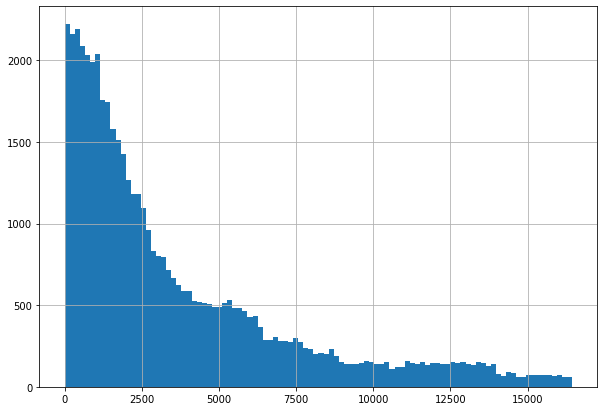

In [33]:
plt.rcParams['figure.figsize'] = (10,7)
data['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

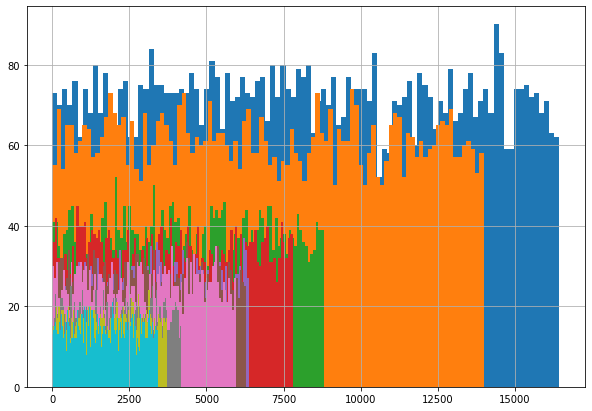

In [34]:
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking'][data['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение. Приведем значения к стандартизированному виду:

In [35]:
means = data.groupby('City')['Ranking'].mean()
std = data.groupby('City')['Ranking'].std()
data['Ranking_std'] = (data.Ranking - data.City.map(means))/(data.City.map(std))

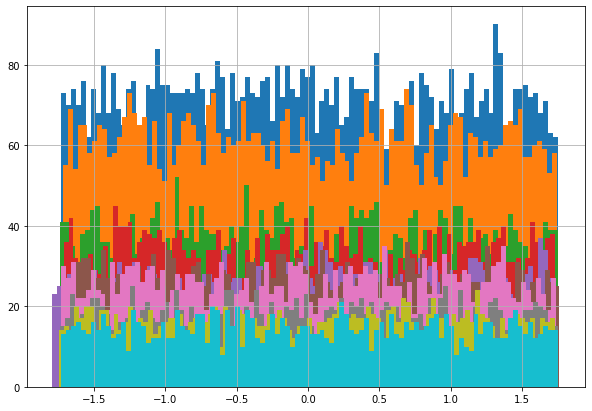

In [36]:
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking_std'][data['City'] == x].hist(bins=100)
plt.show()

### Number of Reviews

Посмотрим сколько всего отзывов оставили в каждом городе:

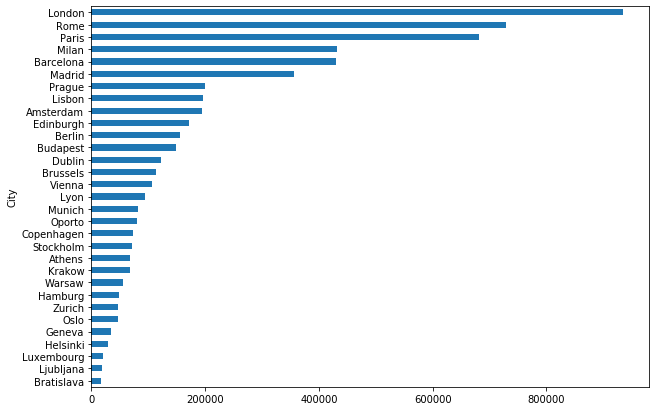

In [37]:
data.groupby('City')['Number of Reviews'].sum().sort_values().plot(kind='barh')

Сравним это с тем, как распределено количество ресторанов по городам:

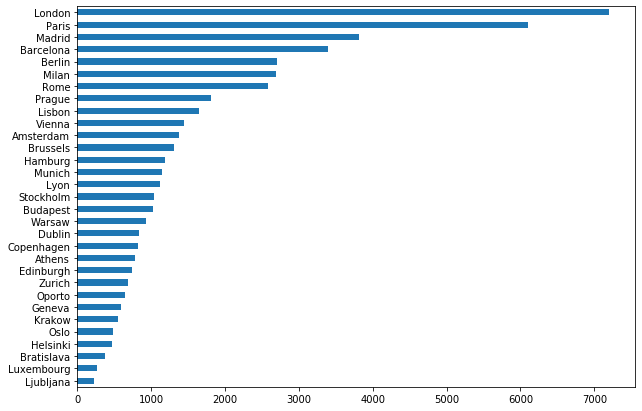

In [38]:
data['City'].value_counts(ascending=True).plot(kind='barh')

Распределение получилось похожим. Чем больше ресторанов в городе, тем больше отзывов о ресторанах по данному городу. Поделим количество отзывов на количество ресторанов в городе и посмотрим распределение:

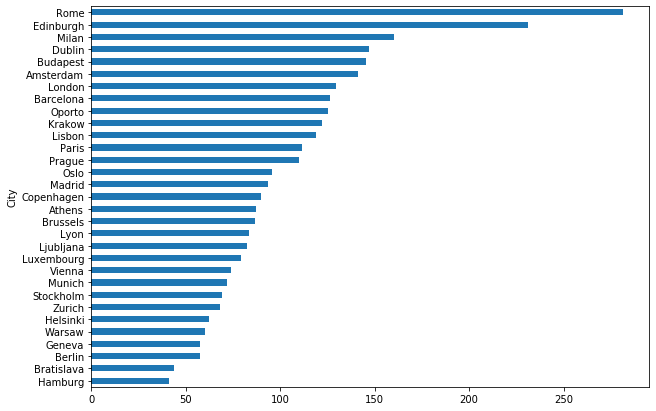

In [39]:
city_sum_reviews = data.groupby('City')['Number of Reviews'].sum()
data['city_sum_reviews'] = data.City.map(city_sum_reviews)
city_count_rest = data.groupby('City').City.count()
data['city_count_rest'] = data.City.map(city_count_rest)
city_reviews_mean = city_sum_reviews/city_count_rest
data['city_reviews_mean'] = data.City.map(city_reviews_mean)

city_reviews_mean.sort_values().plot(kind='barh')

Насколько коррелирует среднее количество отзывов на один ресторан с количеством ресторанов в городе?

In [40]:
np.corrcoef(city_reviews_mean, city_count_rest)

array([[1.        , 0.22850256],
       [0.22850256, 1.        ]])

Данный коэффициент корреляции говорит о том, что есть положительная корреляция между количеством рестораном в городе и средним количеством отзывов на один ресторан. Но величина коэффициента не настолько велика, чтобы полностью объяснить эту взаимосвязь. Действительно, больше всего ресторанов в Лондоне и количество отзывов больше всего тоже в Лондоне, но среднее количество на один ресторан больше всего в Риме.

### Number of Cuisine

Посмотрим, как распределено среднее количество кухонь на один ресторан в каждом городе:

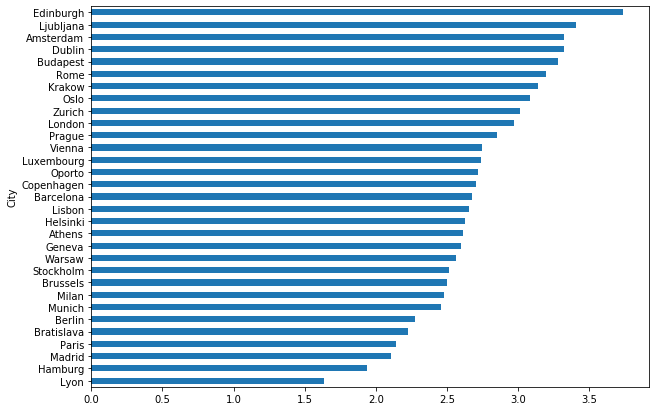

In [41]:
city_sum_cuisine = data.groupby('City')['Number_of_cuisine'].sum()
data['city_sum_cuisine'] = data.City.map(city_sum_cuisine)
city_cuisine_mean = city_sum_cuisine/city_count_rest

city_cuisine_mean.sort_values().plot(kind='barh')

Однозначно стоит когда-нибудь посетить Эдинбург! И в Дублин заодно заглянуть. В Амстердаме уже был.

### Price Range

Посмотрим среднюю ценовую категорию ресторанов в каждом городе:

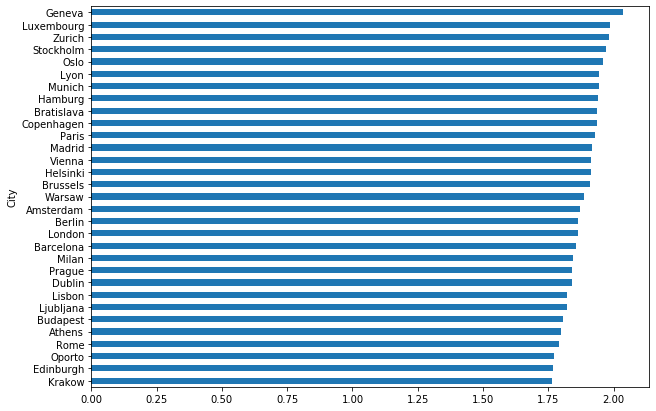

In [42]:
data.groupby('City')['Price Range'].mean().sort_values().plot(kind='barh')

Самые дорогие "в среднем" рестораны оказались, как и ожидалось в Швейцарии - в Женеве и в Цюрихе. И снова радует Эдинбург! И в Краков можно заглянуть недорого поесть, разнообразие кухонь там тоже "в среднем" неплохое.

# Feature Engineering

Посмотрим, что на данный момент творится в датасете и с какими признаками еще можно поработать:

In [43]:
data.sample(5)

,City,Ranking,Price Range,Number of Reviews,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Cuisine Style_isNAN,Price Range_isNAN,...,date1,date2,restaurant_id_count,count_rest_id_in_city,unique_rest_in_city,Ranking_std,city_sum_reviews,city_count_rest,city_reviews_mean,city_sum_cuisine
47316,Berlin,1236.0,1.0,42.0,11707664,1,4.0,0,0,0,...,2017-09-25,2017-09-04,14,1.0,1,-1.111652,155923.0,2705,57.642514,6158
17725,London,15663.0,2.0,14.0,3349108,1,3.0,0,0,0,...,2017-10-02,2017-11-26,1,1.0,1,1.586230,933770.0,7193,129.816488,21357
29364,Paris,1827.0,2.0,352.0,1309227,1,4.0,0,0,0,...,2017-11-12,2017-11-02,8,1.0,1,-1.265258,680827.0,6108,111.464800,13083
44071,Budapest,1580.0,2.0,7.0,7699489,1,4.0,0,1,1,...,2017-10-09,2017-07-24,7,1.0,1,0.513092,148366.0,1021,145.314398,3347
14280,Madrid,1886.0,2.0,70.0,991149,1,4.0,0,0,0,...,2016-02-25,2015-10-11,8,1.0,1,-0.990054,357185.0,3813,93.675584,8033


У нас есть даты отзывов date1 и date2, из которых можно извлечь два новых признака:

### Количество дней, прошедших со дня последнего отзыва на сайте

In [44]:
data['days_from_last_review'] = data[['date1','date2']].apply(lambda x: (max(data['date1'].max(),data['date2'].max())-max(x[0], x[1])).days, axis=1)

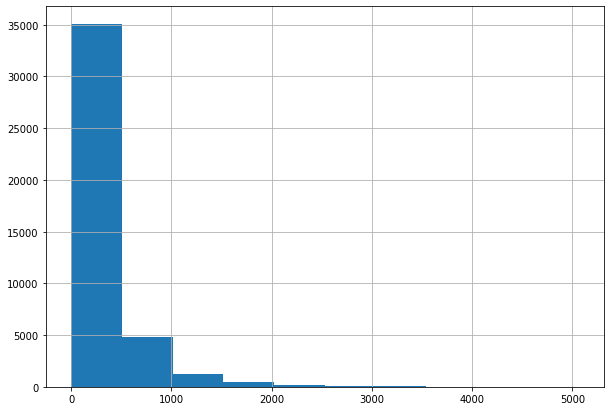

In [45]:
data['days_from_last_review'].hist()

Создадим дополнительный признак для пропущенный значений:

In [46]:
data['days_from_last_review_isNAN'] = pd.isna(data['days_from_last_review']).astype('uint8')

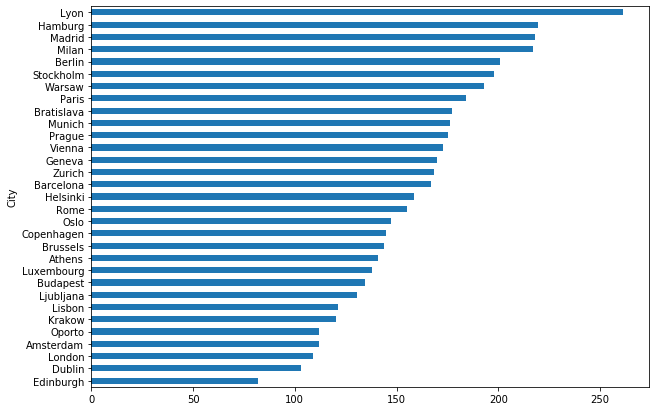

In [47]:
city_days_from_last_review_median = data.groupby('City')['days_from_last_review'].median()
city_days_from_last_review_median.sort_values().plot(kind='barh')

In [48]:
data['days_from_last_review'].describe()

count    41886.000000
mean       290.045361
std        363.252094
min          0.000000
25%         79.000000
50%        153.000000
75%        337.000000
max       5059.000000
Name: days_from_last_review, dtype: float64

Заполним пропуски медианным значением по городу:

In [49]:
data['days_from_last_review'].fillna(data.City.map(city_days_from_last_review_median), inplace=True)

### Разница во времени между двумя последними оставленными отзывами

In [50]:
data['diff_time'] = data[['date1','date2']].apply(lambda x: abs((x[0]-x[1]).days) if x[1] is not None else None, axis=1)

Создадим дополнительный признак для пропущенных значений:

In [51]:
data['diff_time_isNAN'] = pd.isna(data['diff_time']).astype('uint8')

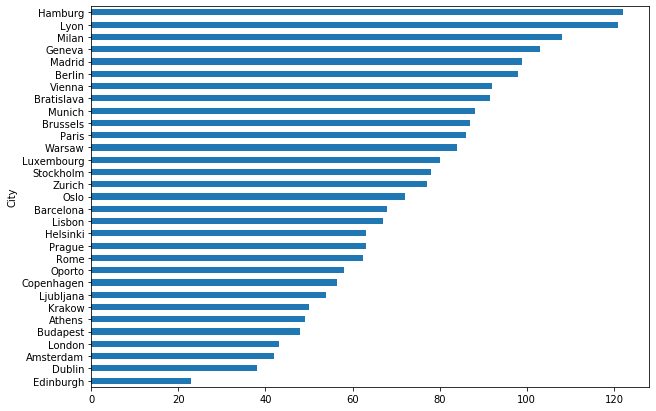

In [52]:
city_diff_time_median = data.groupby('City')['diff_time'].median()
city_diff_time_median.sort_values().plot(kind='barh')

Заполним пропуски медианным значением по городу:

In [53]:
data['diff_time'].fillna(data.City.map(city_diff_time_median), inplace=True)

Посмотрим, что теперь есть в нашем датасете:

In [54]:
data.sample(5)

,City,Ranking,Price Range,Number of Reviews,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Cuisine Style_isNAN,Price Range_isNAN,...,unique_rest_in_city,Ranking_std,city_sum_reviews,city_count_rest,city_reviews_mean,city_sum_cuisine,days_from_last_review,days_from_last_review_isNAN,diff_time,diff_time_isNAN
2538,London,3483.0,2.0,121.0,719384,0,0.0,0,0,0,...,1,-0.992113,933770.0,7193,129.816488,21357,114.0,0,45.0,0
29930,Helsinki,518.0,2.0,14.0,10637959,1,4.0,0,1,1,...,1,-0.141705,29511.0,475,62.128421,1248,209.0,0,12.0,0
4070,Brussels,1204.0,2.0,14.0,5978937,0,0.0,0,0,1,...,1,-0.389923,113956.0,1314,86.724505,3288,88.0,0,1152.0,0
44047,Hamburg,1422.0,2.0,10.0,969913,1,4.5,0,1,1,...,1,0.058753,48853.0,1186,41.191400,2297,928.0,0,122.0,1
38892,London,7417.0,1.0,5.0,12702760,1,5.0,0,0,0,...,1,-0.159338,933770.0,7193,129.816488,21357,72.0,0,30.0,0


Избавимся от ненужных признаков для дальнейшей работы:

In [55]:
data.drop(['date1','date2'], axis = 1, inplace=True)

In [56]:
data.head()

,City,Ranking,Price Range,Number of Reviews,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Cuisine Style_isNAN,Price Range_isNAN,...,unique_rest_in_city,Ranking_std,city_sum_reviews,city_count_rest,city_reviews_mean,city_sum_cuisine,days_from_last_review,days_from_last_review_isNAN,diff_time,diff_time_isNAN
0,Paris,12963.0,2.0,4.0,10746918,0,0.0,0,0,0,...,1,1.491224,680827.0,6108,111.464800,13083,184.0,1,86.0,1
1,Helsinki,106.0,2.0,97.0,6674944,0,0.0,0,0,0,...,1,-1.404530,29511.0,475,62.128421,1248,83.0,0,37.0,0
2,Edinburgh,810.0,2.0,28.0,13129638,0,0.0,0,0,0,...,0,-0.146058,172103.0,745,231.010738,2782,60.0,0,22.0,0
3,London,1669.0,3.0,202.0,680417,0,0.0,0,0,0,...,1,-1.376113,933770.0,7193,129.816488,21357,82.0,0,14.0,0
4,Bratislava,37.0,3.0,162.0,1112354,0,0.0,0,0,0,...,1,-1.673120,16672.0,380,43.873684,847,18.0,0,15.0,0


In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   City                         50000 non-null  object 
 1   Ranking                      50000 non-null  float64
 2   Price Range                  50000 non-null  float64
 3   Number of Reviews            50000 non-null  float64
 4   ID_TA                        50000 non-null  int64  
 5   sample                       50000 non-null  int64  
 6   Rating                       50000 non-null  float64
 7   Number_of_Reviews_isNAN      50000 non-null  uint8  
 8   Cuisine Style_isNAN          50000 non-null  uint8  
 9   Price Range_isNAN            50000 non-null  uint8  
 10  Number_of_cuisine            50000 non-null  int64  
 11  restaurant_id_count          50000 non-null  int64  
 12  count_rest_id_in_city        50000 non-null  float64
 13  unique_rest_in_c

### One-Hot Encoding

Закодируем категориальный признак City с помощью one-hot encoding:

In [58]:
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

In [59]:
data.sample(5)

,Ranking,Price Range,Number of Reviews,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Cuisine Style_isNAN,Price Range_isNAN,Number_of_cuisine,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
33296,2731.0,1.0,4.0,12302510,1,5.0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
49043,39.0,3.0,235.0,697896,1,4.5,0,0,0,5,...,0,0,0,0,0,0,0,0,1,0
13223,1617.0,2.0,162.0,2318782,1,4.0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
29593,13694.0,2.0,81.0,734298,1,3.0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
29686,437.0,2.0,84.0,8087299,1,4.5,0,0,0,8,...,0,0,0,0,0,0,0,0,0,0


Теперь наш датасет готов к тому, чтобы применять модель машинного обучения для составления прогноза рейтинга

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 54 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Ranking                      50000 non-null  float64
 1   Price Range                  50000 non-null  float64
 2   Number of Reviews            50000 non-null  float64
 3   ID_TA                        50000 non-null  int64  
 4   sample                       50000 non-null  int64  
 5   Rating                       50000 non-null  float64
 6   Number_of_Reviews_isNAN      50000 non-null  uint8  
 7   Cuisine Style_isNAN          50000 non-null  uint8  
 8   Price Range_isNAN            50000 non-null  uint8  
 9   Number_of_cuisine            50000 non-null  int64  
 10  restaurant_id_count          50000 non-null  int64  
 11  count_rest_id_in_city        50000 non-null  float64
 12  unique_rest_in_city          50000 non-null  int64  
 13  Ranking_std     

# Model

In [85]:
def fine_rating_pred(prediction):
        if prediction < 0.25:
            return 0
        elif 0.25 < prediction <= 0.75:
            return 0.5
        elif 0.75 < prediction <= 1.25:
            return 1
        elif 1.25 <prediction <= 1.75:
            return 1.5
        elif 1.75 < prediction <= 2.25:
            return 2
        elif 2.25 < prediction <= 2.75:
            return 2.5
        elif 2.75 < prediction <= 3.25:
            return 3
        elif 3.25 < prediction <= 3.75:
            return 3.5
        elif 3.75 < prediction <= 4.25:
            return 4
        elif 4.25 < prediction <= 4.75:
            return 4.5
        else:
            return 5
        
def fine_rating_pred2(prediction):
    return round(prediction*2)/2

def model_randomforestregressor(data, submit=False):
    
    # функция принимает на вход датасет data для построения модели
    # параметр submit отвечает за то, нужно ли сохранять решение в отдельный csv файл
    
    # Импортируем необходимые библиотеки:
    from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
    from sklearn import metrics # инструменты для оценки точности модели

    # Создаём модель
    model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

    # Теперь выделим тестовую часть
    train_data = data.query('sample == 1').drop(['sample'], axis=1)
    test_data = data.query('sample == 0').drop(['sample'], axis=1)

    y = train_data.Rating.values # наш таргет
    X = train_data.drop(['Rating'], axis=1)

    # Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
    # выделим 20% данных на валидацию (параметр test_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
    
    # Обучаем модель на тестовом наборе данных
    model.fit(X_train, y_train)

    # Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
    # Предсказанные значения записываем в переменную y_pred
    y_pred = model.predict(X_test)
    
    # Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
    # Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
    
    y_pred_fine = pd.Series(y_pred).apply(lambda x: fine_rating_pred(x)).values
    print('fine_MAE:', metrics.mean_absolute_error(y_test, y_pred_fine))

    y_pred_fine2 = pd.Series(y_pred).apply(lambda x: fine_rating_pred2(x)).values
    print('fine_MAE2:', metrics.mean_absolute_error(y_test, y_pred_fine2))
    
    # в RandomForestRegressor есть возможность вывести самые важные признаки для модели
    plt.rcParams['figure.figsize'] = (10,10)
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(15).plot(kind='barh')
    
    # Submission
    test_data = test_data.drop(['Rating'], axis=1)

    predict_submission = model.predict(test_data)
    predict_submission = pd.Series(predict_submission).apply(lambda x: fine_rating_pred(x)).values
    
    display(pd.Series(predict_submission).value_counts())
    
    sample_submission['Rating'] = predict_submission
    display(sample_submission.head(10))
    
    if submit:    
        sample_submission.to_csv('submission23.csv', index=False)

In [62]:
#model_randomforestregressor(data)

### Дополнительные признаки из внешних источников: Population, Capital

Из внешних источников добавим данные по количеству населения в городе. Рассчитаем также еще один дополнительный признак - сколько людей в городе приходится на один ресторан.

In [86]:
data2 = data.copy()

city_population = {
    'London': 8173900,
    'Paris': 2240621,
    'Madrid': 3155360,
    'Barcelona': 1593075,
    'Berlin': 3326002,
    'Milan': 1331586,
    'Rome': 2870493,
    'Prague': 1272690,
    'Lisbon': 547733,
    'Vienna': 1765649,
    'Amsterdam': 825080,
    'Brussels': 144784,
    'Hamburg': 1718187,
    'Munich': 1364920,
    'Lyon': 496343,
    'Stockholm': 1981263,
    'Budapest': 1744665,
    'Warsaw': 1720398,
    'Dublin': 506211 ,
    'Copenhagen': 1246611,
    'Athens': 3168846,
    'Edinburgh': 476100,
    'Zurich': 402275,
    'Oporto': 221800,
    'Geneva': 196150,
    'Krakow': 756183,
    'Oslo': 673469,
    'Helsinki': 574579,
    'Bratislava': 413192,
    'Luxembourg': 576249,
    'Ljubljana': 277554
}

capital = {
    'London': 1,
    'Paris': 1,
    'Madrid': 1,
    'Barcelona': 0,
    'Berlin': 1,
    'Milan': 0,
    'Rome': 1,
    'Prague': 1,
    'Lisbon': 1,
    'Vienna': 1,
    'Amsterdam': 1,
    'Brussels': 1,
    'Hamburg': 0,
    'Munich': 0,
    'Lyon': 0,
    'Stockholm': 1,
    'Budapest': 1,
    'Warsaw': 1,
    'Dublin': 1,
    'Copenhagen': 1,
    'Athens': 1,
    'Edinburgh': 1,
    'Zurich': 1,
    'Oporto': 0,
    'Geneva': 1,
    'Krakow': 0,
    'Oslo': 1,
    'Helsinki': 1,
    'Bratislava': 1,
    'Luxembourg': 1,
    'Ljubljana': 1
}

# вот нам и пригодилась копия исходного датасета, чтобы обращаться к значению City

data2['population'] = data1['City'].map(city_population)

data2['capital'] = data1['City'].map(capital)
    
data2['people_per_rest'] = data2['population'] / data2['city_count_rest']

# стандартизация ранга ресторана относительно количества отзывов в городе

city_reviews_sum = data1.groupby('City')['Number of Reviews'].sum()

data2['rank_per_city_reviews_sum'] = data['Ranking']/ data1['City'].map(city_reviews_sum)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


MAE: 0.19547187500000002
fine_MAE: 0.16275
fine_MAE2: 0.1625


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


4.0    3756
4.5    2749
3.5    1697
3.0     734
5.0     722
2.5     195
2.0      75
1.0      40
1.5      32
dtype: int64

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,1.5
7,id_7,3.0
8,id_8,4.0
9,id_9,4.5


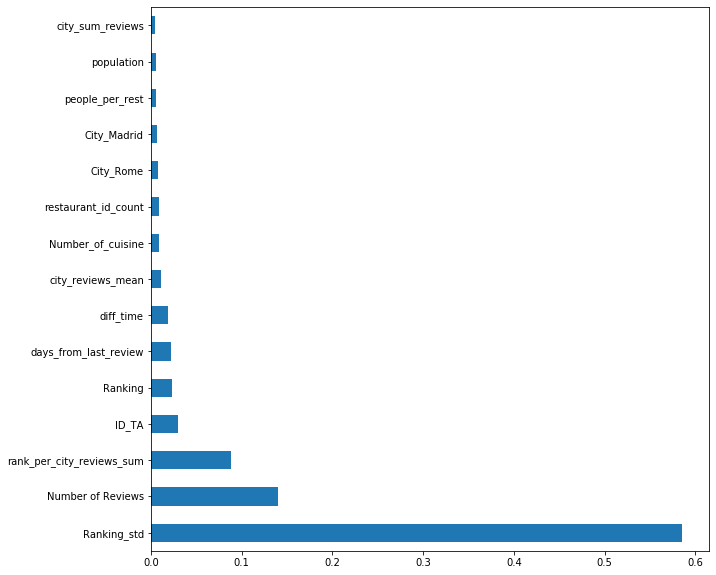

In [87]:
model_randomforestregressor(data2, submit=True)

In [65]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 58 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Ranking                      50000 non-null  float64
 1   Price Range                  50000 non-null  float64
 2   Number of Reviews            50000 non-null  float64
 3   ID_TA                        50000 non-null  int64  
 4   sample                       50000 non-null  int64  
 5   Rating                       50000 non-null  float64
 6   Number_of_Reviews_isNAN      50000 non-null  uint8  
 7   Cuisine Style_isNAN          50000 non-null  uint8  
 8   Price Range_isNAN            50000 non-null  uint8  
 9   Number_of_cuisine            50000 non-null  int64  
 10  restaurant_id_count          50000 non-null  int64  
 11  count_rest_id_in_city        50000 non-null  float64
 12  unique_rest_in_city          50000 non-null  int64  
 13  Ranking_std     